In [27]:
import numpy as np
import pandas as pd
import pickle
import os
from string import punctuation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [28]:
with open('poems.txt',  encoding='utf8') as f:
    poems = f.readlines()
    poems = ''.join(str(e) for e in poems if not e.isdigit())

In [29]:
vocab = ''.join(sorted(set(poems)))

In [30]:
char2int = {c: i for i, c in enumerate(vocab)}
int2char = {i: c for i, c in enumerate(vocab)}

In [31]:
pickle.dump(char2int, open('char2int.pickle', 'wb'))
pickle.dump(int2char, open('int2char.pickle', 'wb'))

In [32]:
encoded_text = np.array([char2int[c] for c in poems])

In [33]:
char_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)

In [34]:
for char in char_dataset.take(10):
    print(char.numpy(), int2char[char.numpy()])

45 S
60 h
57 e
2  
55 c
67 o
73 u
64 l
56 d
66 n


In [35]:
sequence_length = 100
BATCH_SIZE = 256
EPOCHS = 70

In [36]:
sequences = char_dataset.batch(2*sequence_length + 1, drop_remainder = True)

In [37]:
for sequence in sequences.take(1):
    print(''.join([int2char[i] for i in sequence.numpy()]))

She couldn't help but sting my finger,

clinging a moment before I flung her

to the ground. Her gold is true, not the trick

evening light plays on my roses.

She curls into herself, stinger twitching


In [38]:
def split_sample(sample):
    ds = tf.data.Dataset.from_tensors((sample[:sequence_length], sample[sequence_length]))
    for i in range(1, (len(sample)-1) // 2):
        input_ = sample[i: i+sequence_length]
        target = sample[i+sequence_length]
        other_ds = tf.data.Dataset.from_tensors((input_, target))
        ds = ds.concatenate(other_ds)
    return ds

In [39]:
dataset = sequences.flat_map(split_sample)

In [40]:
def one_hot_samples(input_, target):
    return tf.one_hot(input_, len(vocab)), tf.one_hot(target, len(vocab))

In [41]:
dataset = dataset.map(one_hot_samples)

In [42]:
for element in dataset.take(2):
    print('Input:', ''.join([int2char[np.argmax(char_vector)] for char_vector in element[0].numpy()]))
    print('Target:', int2char[np.argmax(element[1].numpy())])
    print('Input shape:', element[0].shape)
    print('Target shape:', element[1].shape)
    print('='*50, '\n')

Input: She couldn't help but sting my finger,

clinging a moment before I flung her

to the ground. Her gol
Target: d
Input shape: (100, 99)
Target shape: (99,)

Input: he couldn't help but sting my finger,

clinging a moment before I flung her

to the ground. Her gold
Target:  
Input shape: (100, 99)
Target shape: (99,)



In [43]:
ds = dataset.repeat().shuffle(1024).batch(BATCH_SIZE, drop_remainder = True)

In [44]:
model = Sequential([LSTM(256, input_shape = (sequence_length, len(vocab)), return_sequences = True),
                   Dropout(0.3),
                   LSTM(256),
                   Dense(len(vocab), activation = 'softmax'),
                   ])

In [45]:
model_weights_path = f'{sequence_length}.h5'
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 256)          364544    
                                                                 
 dropout_1 (Dropout)         (None, 100, 256)          0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dense_1 (Dense)             (None, 99)                25443     
                                                                 
Total params: 915,299
Trainable params: 915,299
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [47]:
model.fit(ds, steps_per_epoch = (len(encoded_text) - sequence_length) // BATCH_SIZE, epochs = EPOCHS)
model.save(model_weights_path)

Epoch 1/70
422/422 [==============================] - 32s 71ms/step - loss: 3.0085 - accuracy: 0.1999
Epoch 2/70
422/422 [==============================] - 30s 71ms/step - loss: 2.4973 - accuracy: 0.3042
Epoch 3/70
422/422 [==============================] - 30s 72ms/step - loss: 2.3084 - accuracy: 0.3420
Epoch 4/70
422/422 [==============================] - 30s 72ms/step - loss: 2.2044 - accuracy: 0.3668
Epoch 5/70
422/422 [==============================] - 31s 72ms/step - loss: 2.1278 - accuracy: 0.3834
Epoch 6/70
422/422 [==============================] - 31s 73ms/step - loss: 2.0669 - accuracy: 0.3977
Epoch 7/70
422/422 [==============================] - 31s 73ms/step - loss: 2.0102 - accuracy: 0.4107
Epoch 8/70
422/422 [==============================] - 31s 73ms/step - loss: 1.9561 - accuracy: 0.4229
Epoch 9/70
422/422 [==============================] - 31s 73ms/step - loss: 1.9041 - accuracy: 0.4347
Epoch 10/70
422/422 [==============================] - 31s 73ms/step - loss: 2.305

In [51]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy'])


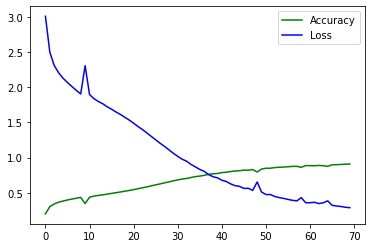

In [64]:
import matplotlib.pyplot as plt
accuracy = model.history.history['accuracy']
loss = model.history.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'g')
plt.plot(epochs, loss, 'b')
plt.legend(['Accuracy','Loss'])
plt.show()